In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import os
from PIL import Image, UnidentifiedImageError
import shutil

# Configuration
IMG_SIZE = (28, 28)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.4
SEED = 42
ROOT_PATH = ''
DATASET_PATH = os.path.join(ROOT_PATH,"raw_data")
CORRUPT_PATH = os.path.join(ROOT_PATH,"corrupt_images")
os.makedirs(CORRUPT_PATH, exist_ok=True)

for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".gif"]:
            path = os.path.join(root, file)
            try:
                with Image.open(path) as img:
                    img.verify()  # Check integrity
            except (UnidentifiedImageError, OSError, IOError) as e:
                # Move the corrupt image
                print(f"Corrupt image found: {path} — moving to {CORRUPT_PATH}")
                dest_path = os.path.join(CORRUPT_PATH, os.path.relpath(path, DATASET_PATH))
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                shutil.move(path, dest_path)

LANDMARK_DIR = os.path.join(ROOT_PATH,"data")
RAW_IMAGE_DIR = os.path.join(ROOT_PATH,"raw_data")
FILTERED_IMAGE_DIR = os.path.join(ROOT_PATH,"filtered_raw_data")
DATASET_PATH = FILTERED_IMAGE_DIR
# Supported image extensions
IMAGE_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.bmp']

# Create filtered output structure
os.makedirs(FILTERED_IMAGE_DIR, exist_ok=True)

for class_name in os.listdir(LANDMARK_DIR):
    if class_name == 'debug':
        continue
    landmark_class_dir = os.path.join(LANDMARK_DIR, class_name)
    raw_class_dir = os.path.join(RAW_IMAGE_DIR, class_name)
    filtered_class_dir = os.path.join(FILTERED_IMAGE_DIR, class_name)
    os.makedirs(filtered_class_dir, exist_ok=True)

    for file in os.listdir(landmark_class_dir):
        if not file.endswith("_landmarks.json"):
            continue

        # Get base filename without "_landmarks.json"
        base_name = file.replace("_landmarks.json", "")

        # Look for corresponding image in raw directory
        for ext in IMAGE_EXTENSIONS:
            image_file = os.path.join(raw_class_dir, base_name + ext)
            if os.path.exists(image_file):
                # Copy to filtered folder
                shutil.copy(image_file, os.path.join(filtered_class_dir, os.path.basename(image_file)))
                break

# Load training dataset with validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    color_mode="grayscale",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
num_classes = len(train_ds.class_names)
label_map = train_ds.class_names

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    color_mode="grayscale",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = val_ds.shard(2,0)
val_ds = val_ds.shard(2,1)
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
# Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 1722 files belonging to 25 classes.
Using 1034 files for training.
Found 1722 files belonging to 25 classes.
Using 688 files for validation.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization,Input
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
model = Sequential([
    Input((28, 28, 1)),
    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    GlobalAveragePooling2D(),
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [3]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.0330 - loss: 3.2906 - val_accuracy: 0.0536 - val_loss: 3.2048
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1316 - loss: 2.9325 - val_accuracy: 0.0744 - val_loss: 3.1997
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1729 - loss: 2.8238 - val_accuracy: 0.0387 - val_loss: 3.1962
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1702 - loss: 2.7346 - val_accuracy: 0.0387 - val_loss: 3.2049
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2110 - loss: 2.6178 - val_accuracy: 0.0387 - val_loss: 3.2202
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2411 - loss: 2.5069 - val_accuracy: 0.0387 - val_loss: 3.2863
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2843 - loss: 2.4128 - val_accuracy: 0.0387 - val_loss: 3.3748
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3216 - loss: 2.2604 - val_accuracy: 0.0387 - val_loss

In [4]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7739 - loss: 0.7912
Test Accuracy: 0.7784
Test Loss: 0.7928


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

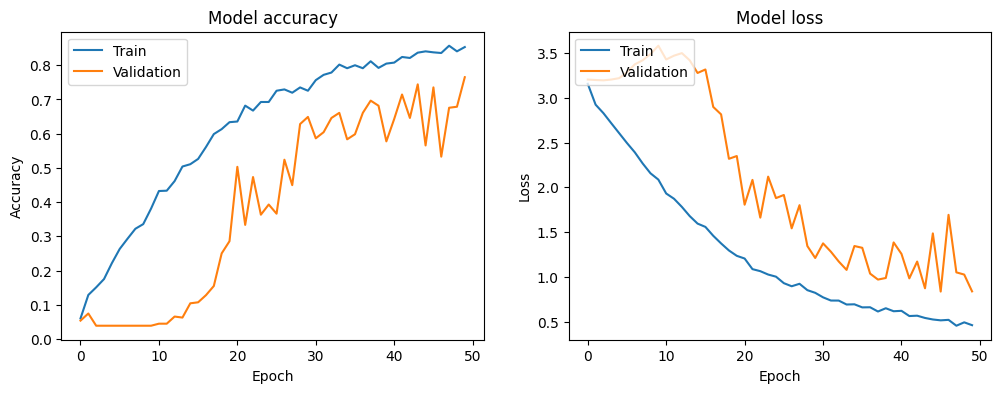

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

               precision    recall  f1-score   support

         baca      0.857     0.667     0.750         9
        bantu      1.000     0.286     0.444         7
        bapak      0.688     0.917     0.786        12
buangairkecil      1.000     0.800     0.889         5
         buat      0.778     0.583     0.667        12
         halo      0.455     0.909     0.606        11
          ibu      0.375     1.000     0.545         3
         kamu      0.842     0.696     0.762        23
         maaf      0.762     0.889     0.821        18
        makan      1.000     0.700     0.824        10
          mau      0.950     0.905     0.927        21
         nama      0.667     0.706     0.686        17
         pagi      0.870     0.833     0.851        24
        paham      0.941     0.762     0.842        21
        sakit      1.000     0.333     0.500         6
    sama-sama      0.846     0.786     0.815        28
         saya      0.500     0.600     0.545         5
      sel

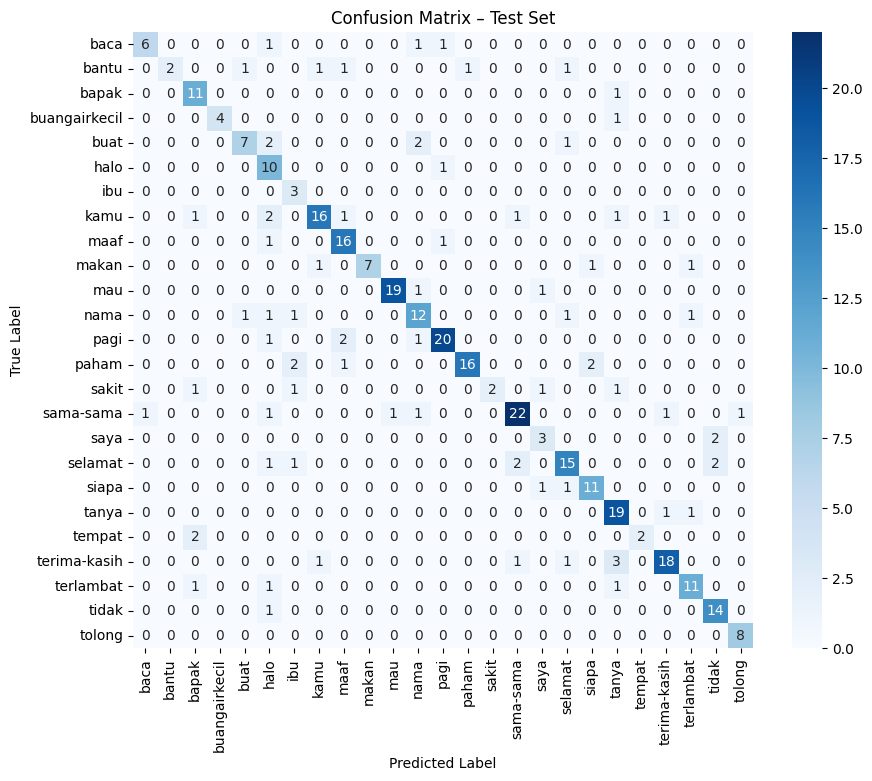

In [7]:
y_true, y_pred = [], []
target_names = [label_map[i] for i in range(len(label_map))]
for X_batch, y_batch in test_ds:
    y_true.append(y_batch.numpy())

    batch_pred = model.predict(X_batch, verbose=0)
    y_pred.append(np.argmax(batch_pred, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print(classification_report(
    y_true, y_pred,
    digits=3,                            
    target_names=target_names 
))

cm = confusion_matrix(y_true, y_pred, labels=range(len(label_map)))
labels = [label_map[i] for i in range(len(label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test Set")
plt.show()